In [25]:
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Flatten

In [3]:
def vgginnet(inp_shape, num_classes, name, include_top=False, weights_path=None):
    base_model = VGG16(include_top=False, input_shape=inp_shape)

    feature_ex_model = Model(inputs=base_model.input,
                             outputs=base_model.get_layer('block4_pool').output,
                             name='vgg16_features')
    feature_ex_model.trainable = False

    image_input = Input(inp_shape, name='image_input')
    x = Lambda(vgg_preprocess, name='vgg_preprocess')(image_input)

    x = feature_ex_model(x)
    feature_ex_model = Model(inputs=image_input, outputs=x)
    x = feature_ex_model.output

    def naive_inception_module(layer_in, f1, f2, f3):
        # 1x1 conv
        conv1 = Conv2D(f1, (1,1), padding='same',
                       activation='relu', name='inception_block/conv_1x1')(layer_in)
        # 3x3 conv
        conv3 = Conv2D(f2, (3,3), padding='same',
                       activation='relu', name='inception_block/conv_3x3')(layer_in)
        # 5x5 conv
        conv5 = Conv2D(f3, (5,5), padding='same',
                       activation='relu', name='inception_block/conv_5x5')(layer_in)
        # 3x3 max pooling
        pool = MaxPooling2D((3,3), strides=(1,1), 
                            padding='same', name='inception_block/pool')(layer_in)
        # concatenate filters, assumes filters/channels last
        layer_out = Concatenate(name='inception_block/add')(
            [conv1, conv3, conv5, pool])
        return layer_out

    x = naive_inception_module(x, 64, 128, 32)
    x = BatchNormalization(name='batch_norm')(x)
    
    if include_top:
        x = Flatten(name='flatten')(x)
        x = Dropout(0.4, name='dropout')(x)
        x = Dense(num_classes, activation='softmax', name='preds')(x)
    
    model = Model(inputs=image_input, outputs=x, name=name)
    model.summary()
    
    if weights_path:
        model.load_weights(weights_path)
    
    return model

In [4]:
wt_path = "../VGGINET-SemiFinal/VGGINet/40X/1/model.h5"

breakhis_vgginnet = vgginnet((224, 224, 3), 2, 
                             'breakhis_vgginnet', include_top=True,
                             weights_path=wt_path)

Model: "breakhis_vgginnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg_preprocess (Lambda)         (None, 224, 224, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     vgg_preprocess[0][0]             
__________________________________________________________________________________________________
inception_block/conv_1x1 (Conv2 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
__________________________________________________________________________________

In [17]:
layer_names = [
    'inception_block/conv_1x1',
    'inception_block/conv_3x3',
    'inception_block/conv_5x5',
    'inception_block/pool'
]
reqd_layer_outputs = [
    breakhis_vgginnet.get_layer(layer_name).output
    for layer_name in layer_names
]

activation_model = Model(
    inputs=breakhis_vgginnet.input,
    outputs=reqd_layer_outputs)
activation_model.outputs

[<tf.Tensor 'inception_block/conv_1x1/Relu:0' shape=(None, 14, 14, 64) dtype=float32>,
 <tf.Tensor 'inception_block/conv_3x3/Relu:0' shape=(None, 14, 14, 128) dtype=float32>,
 <tf.Tensor 'inception_block/conv_5x5/Relu:0' shape=(None, 14, 14, 32) dtype=float32>,
 <tf.Tensor 'inception_block/pool/MaxPool:0' shape=(None, 14, 14, 512) dtype=float32>]

In [30]:
sample_image = tf.image.decode_png(
    tf.io.read_file('sample.png'))
sample_image = tf.image.resize(sample_image,
                               [224, 224])
sample_image = tf.cast(sample_image, tf.float32)
sample_image = tf.expand_dims(sample_image, axis=0)

activations = activation_model.predict(sample_image)




inception_block/conv_1x1


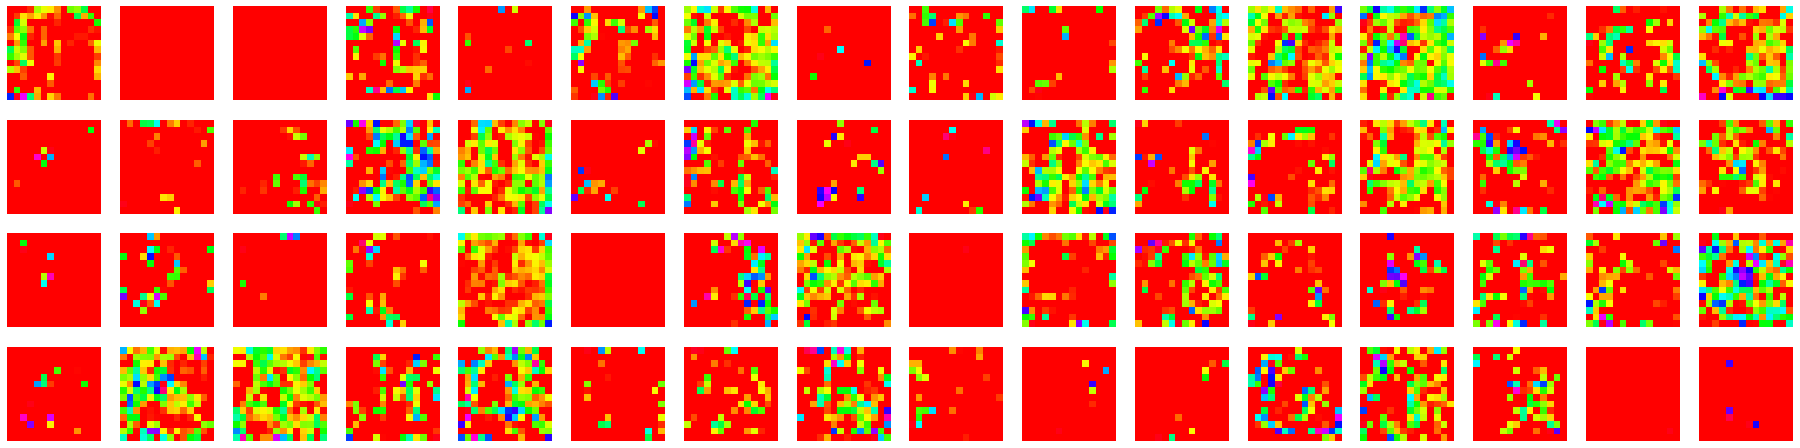




inception_block/conv_3x3


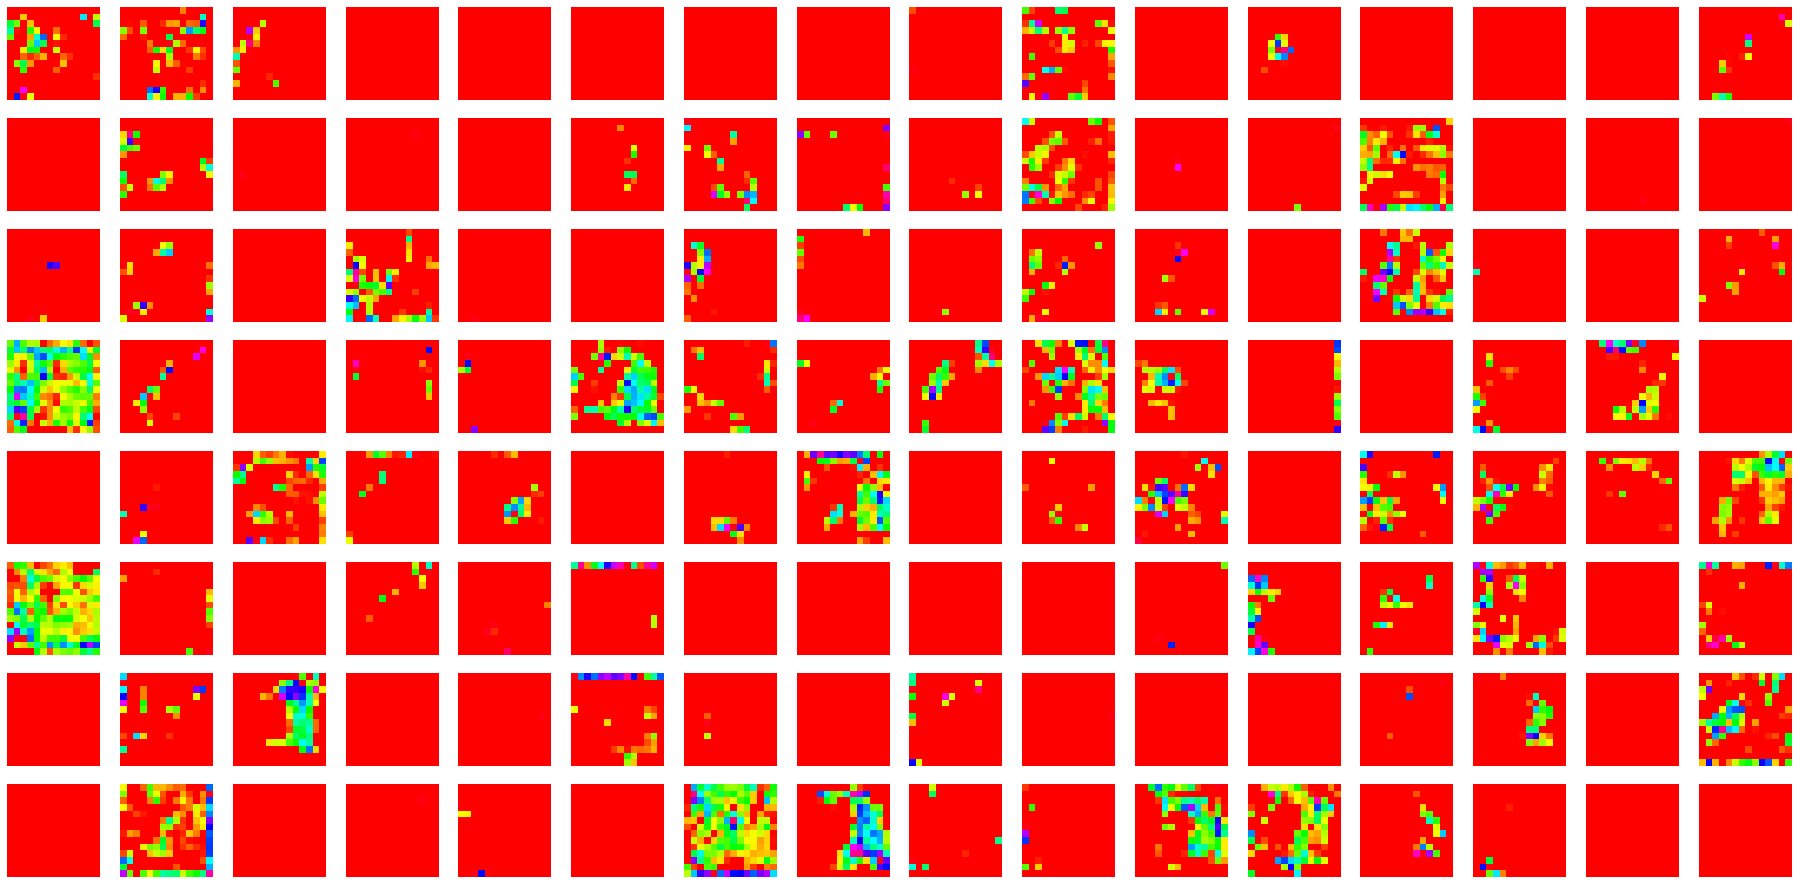




inception_block/conv_5x5


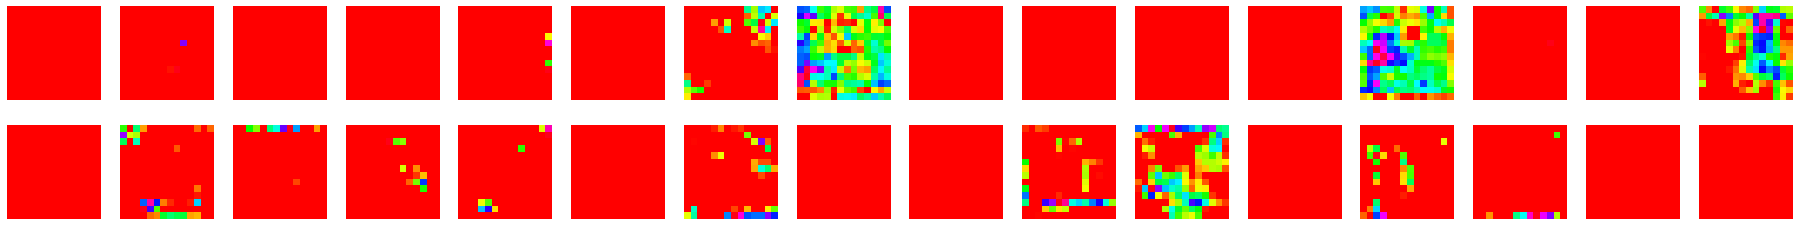




inception_block/pool


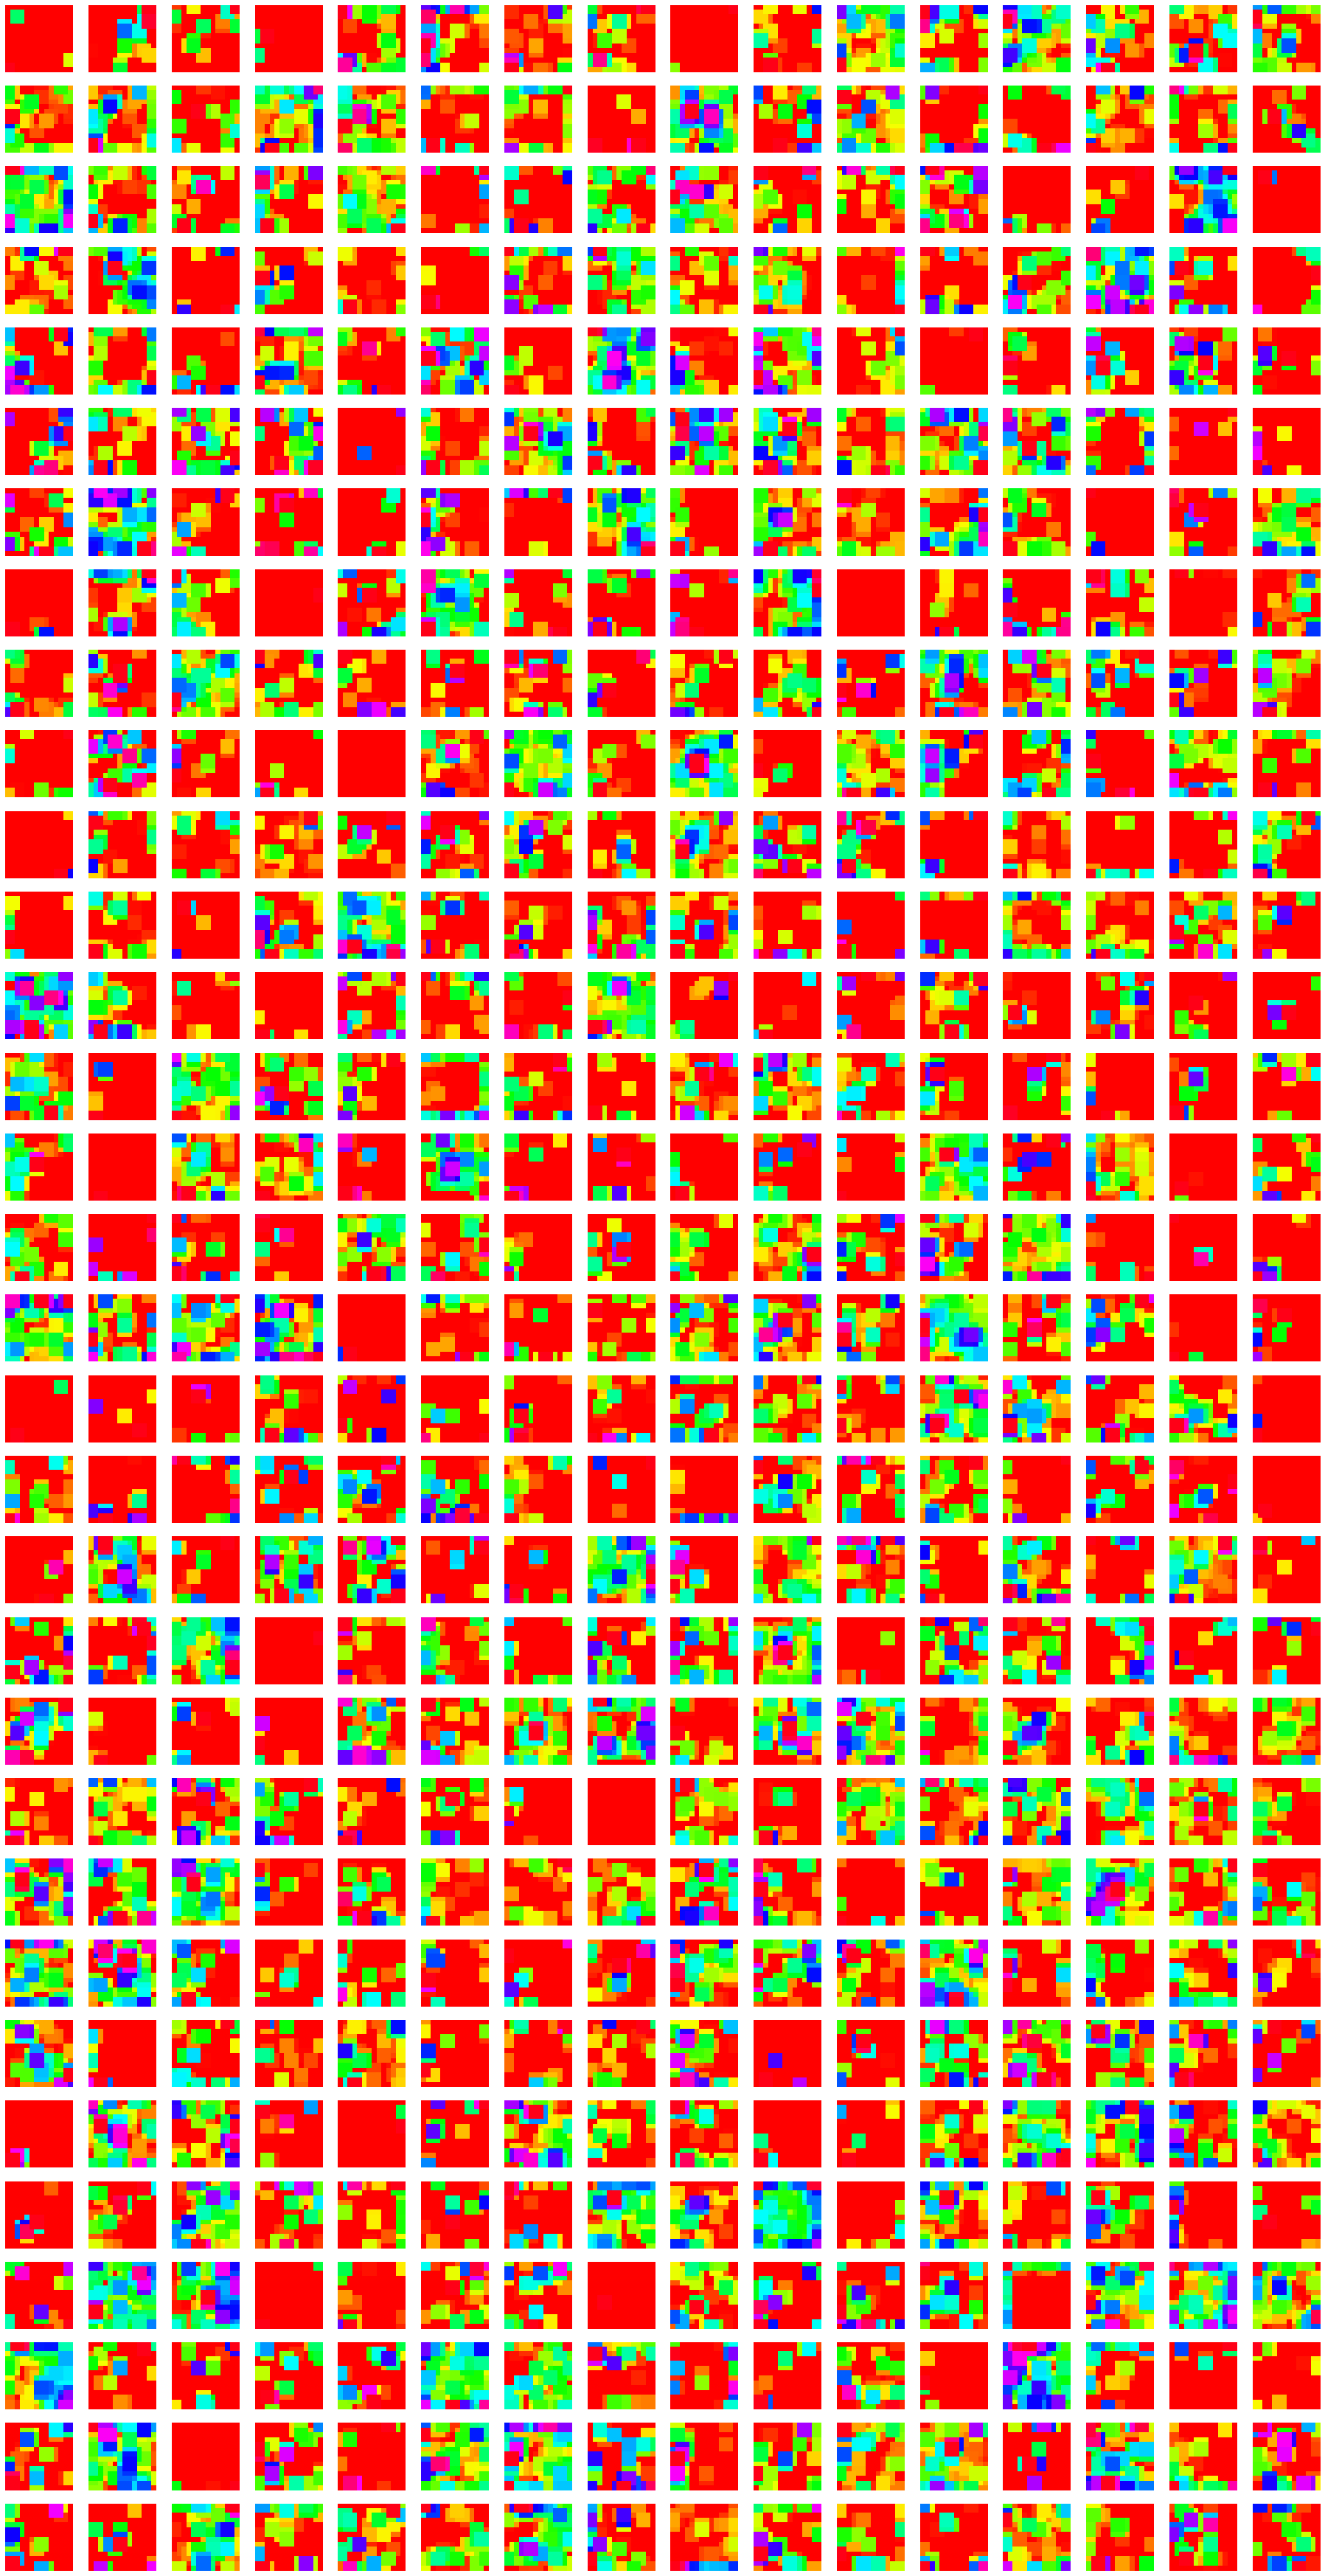

In [36]:
col_size = 16

for layer_name, activation in zip(layer_names, activations):
    max_val = activation.max()
    activation /= max_val

    num_filters = activation.shape[-1]
    row_size = num_filters // col_size

    print("\n" * 2)
    print(layer_name)
    plt.figure(figsize=[col_size * 2, row_size * 2])
    for index in range(num_filters):
        plt.subplot(row_size, col_size, index + 1)
        plt.imshow(activation[0, :, :, index], cmap='hsv')
        plt.axis("off")
    plt.savefig(('layer_visualization_%s.svg' % layer_name).replace('/', '_'))
    plt.show()

In [40]:
vgg_activation_model = breakhis_vgginnet.get_layer('vgg16_features')
vgg_activation_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [41]:
preprocessed_sample_image = vgg_preprocess(sample_image)
preprocessed_sample_image.shape

TensorShape([1, 224, 224, 3])

In [42]:
activation = vgg_activation_model.predict(preprocessed_sample_image)
activation.shape

(1, 14, 14, 512)




vgg16/block4_pool


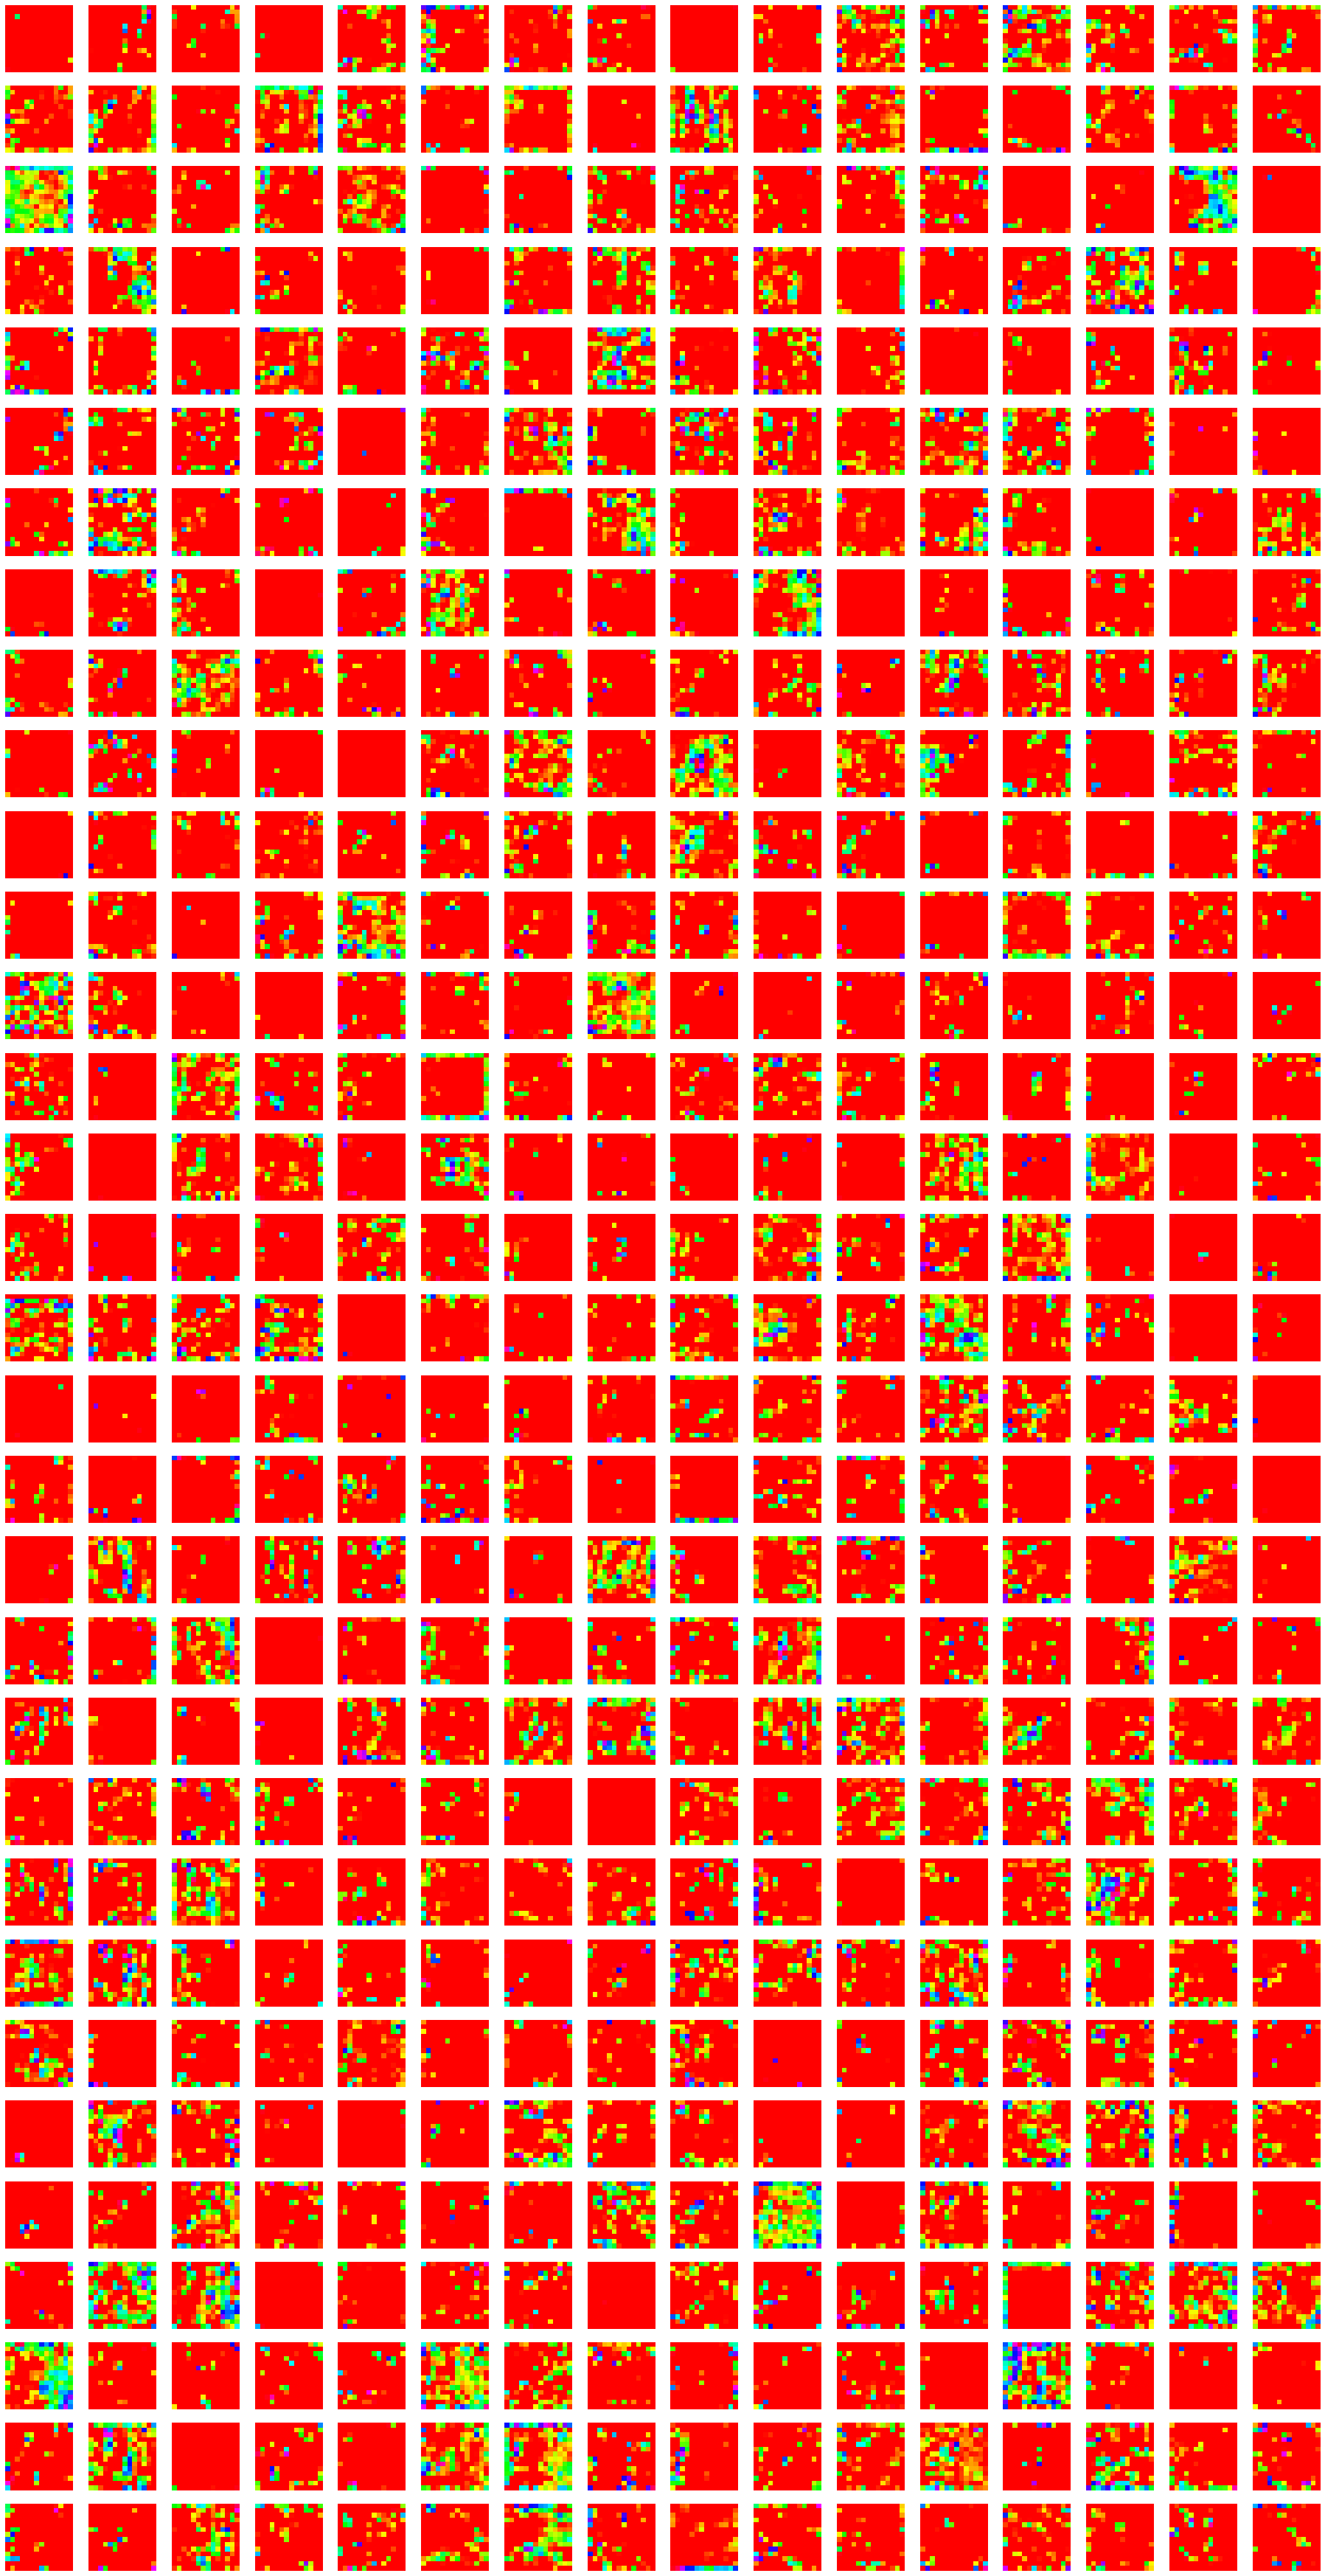

In [43]:
col_size = 16

layer_name = 'vgg16/block4_pool'
max_val = activation.max()
activation /= max_val

num_filters = activation.shape[-1]
row_size = num_filters // col_size

print("\n" * 2)
print(layer_name)
plt.figure(figsize=[col_size * 2, row_size * 2])
for index in range(num_filters):
    plt.subplot(row_size, col_size, index + 1)
    plt.imshow(activation[0, :, :, index], cmap='hsv')
    plt.axis("off")
plt.savefig(('layer_visualization_%s.svg' % layer_name).replace('/', '_'))
plt.show()